## The problem

- Walking around in a 2D maze
- This is a toy problem, we will make it more challenging later

In [1]:
import gym
from gym.spaces import Discrete
import numpy as np
import ray
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.models.preprocessors import get_preprocessor 
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import copy

In [2]:
# import tensorflow as tf
# # import tensorflow.compat.v1 as tf

In [3]:
import torch

In [4]:
action_names = {
    0 : "up",
    1 : "down",
    2 : "right",
    3 : "left"
}

In [5]:
ray.init(ignore_reinit_error=True)

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:6379',
 'object_store_address': '/tmp/ray/session_2022-04-06_07-37-15_554531_28574/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-04-06_07-37-15_554531_28574/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-04-06_07-37-15_554531_28574',
 'metrics_export_port': 64455,
 'gcs_address': '127.0.0.1:57673',
 'node_id': '35219adb9d34bf4d7f4c255312246c12dbae816a9f531aaff52f303d'}

In [6]:
class MazeEnvironment(gym.Env): 
    def __init__(self, env_config):
        self.ylen = env_config.get("ylen", 5)
        self.xlen = env_config.get("xlen", 5)
        
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Discrete(self.ylen*self.xlen)
    
    def reset(self, seed=42):
        self.player = (0, 0)
        self.exit = (self.ylen-1, self.xlen-1)
        if seed is not None:
            np.random.seed(seed)
        self.walls = np.random.rand(self.ylen, self.xlen) < 0.2
        self.walls[self.player] = 0
        self.walls[self.exit] = 0
        self.num_steps = 0
        return self.get_observation()
    
    def get_observation(self):
        return self.player[0] + self.ylen*self.player[1] # TODO: FIX TO MATCH THE ONE BELOW SO IT GOES ROWS FIRST
    
    def step(self, action):
        self.num_steps += 1
        
        if action == 0: # move up
            new_loc = (self.player[0]-1, self.player[1])
            if new_loc[0] > 0 and not self.walls[new_loc]:
                self.player = new_loc
        
        elif action == 1: # move down
            new_loc = (self.player[0]+1, self.player[1])
            if new_loc[0] < self.ylen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 2: # move right
            new_loc = (self.player[0], self.player[1]+1)
            if new_loc[1] < self.xlen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 3: # move left
            new_loc = (self.player[0], self.player[1]-1)
            if new_loc[1] > 0 and not self.walls[new_loc]:
                self.player = new_loc
                
        else:
            raise Exception("Action must be {0,1,2,3}")
                
        info = {"player pos" : self.player}
        
        return self.get_observation(), self.get_reward(), self.is_done(), info


    def get_reward(self):
        # return self.player == self.exit
        dist = np.abs(self.player[0]-self.exit[0]) + np.abs(self.player[1]-self.exit[1])
        return -dist
    
    def is_done(self):
        return self.player == self.exit or self.num_steps >= 500

    def render(self):
        for i in range(self.xlen):
            for j in range(self.ylen):
                if (i,j) == self.exit:
                    print("E", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.walls[i,j]:
                    print("X", end="")
                else:
                    print(".", end="")
                # print("O", end="")
            print()

In [7]:
# BY DEFAULT USES SEED 22
me = MazeEnvironment({})
me.reset()
me.render()

P...X
XX...
X...X
X....
.X..E


In [8]:
# sorted(trainer.config)

In [9]:
trainer_config = {
    "num_workers": 1,
    # "model": {
    #     "fcnet_hiddens": [64, 64],
    #     "fcnet_activation": "relu",
    # },
    "evaluation_num_workers": 1,
    # "evaluation_interval" : 1,
    "create_env_on_driver" : True,
    # "evaluation_config": {
    #     "render_env": True,
    # },
    "log_level" : "ERROR",
    "framework" : "torch" # default is tf
}

trainer = DQNTrainer(trainer_config, env=MazeEnvironment)

2022-04-06 07:37:18,224	WARNING trainer.py:2279 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-04-06 07:37:18,225	INFO simple_q.py:153 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-04-06 07:37:18,225	INFO trainer.py:790 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


In [10]:
rewards = []
for episode in range(10):
    print(episode)
    out = trainer.train();
    rewards.append(out['episode_reward_mean'])

0
1
2
3
4
5
6
7
8
9


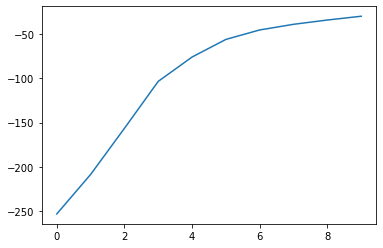

In [11]:
plt.plot(rewards);

In [12]:
out;

In [13]:
me = MazeEnvironment({})
obs = me.reset() # BY DEFAULT USES SEED 22
me.render()

P...X
XX...
X...X
X....
.X..E


In [14]:
action = trainer.compute_single_action(input_dict={"obs": obs}, explore=False)
res = me.step(action)
obs = res[0]
me.render()

print("\naction:", action_names[action])
print("reward:", res[1])
print("done:", res[2])

.P..X
XX...
X...X
X....
.X..E

action: right
reward: -7
done: False


try with a fresh trainer to make sure it does badly:

In [15]:
new_trainer = DQNTrainer(trainer_config, env=MazeEnvironment)
me = MazeEnvironment({})
obs = me.reset() 
me.render()

P...X
XX...
X...X
X....
.X..E


In [16]:
action = new_trainer.compute_single_action(input_dict={"obs": obs}, explore=False)
res = me.step(action)
obs = res[0]
me.render()

P...X
XX...
X...X
X....
.X..E


back to orig trainer:

In [17]:
trainer.config["evaluation_config"]["explore"]

False

In [18]:
trainer.evaluate()

{'evaluation': {'episode_reward_max': -28.0,
  'episode_reward_min': -28.0,
  'episode_reward_mean': -28.0,
  'episode_len_mean': 8.0,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0],
   'episode_lengths': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.30388066798080626,
   'mean_inference_ms': 0.6274293970178675,
   'mean_action_processing_ms': 0.024139145274221164,
   'mean_env_wait_ms': 0.07967595700864438,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

In [19]:
policy = trainer.get_policy()
model = policy.model

In [20]:
obs_space = me.observation_space
preprocessor = get_preprocessor(obs_space)(obs_space)
observations = me.reset()
transformed = preprocessor.transform(observations).reshape(1, -1)

In [21]:
transformed

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [22]:
model_output, _ = model({"obs": torch.from_numpy(transformed)})

In [23]:
model_output.shape

torch.Size([1, 256])

In [33]:
q_values = model.get_q_value_distributions(model_output)[0]

In [34]:
print(model)

FullyConnectedNetwork_as_DQNTorchModel(
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=25, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (A): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=4, bias=True)
      )
    )
  )
  (value_module): Sequential(
    (dueling_V_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (V): 

In [35]:
q_values

tensor([[-2.6977, -2.7273,  5.1072, -2.6512]], grad_fn=<AddmmBackward0>)

In [36]:
ac = trainer.compute_single_action(input_dict={"obs": observations}, explore=False)
ac

2

In [37]:
action_names[ac]

'right'

In [38]:
action_distribution = policy.dist_class(model_output, model) 
action_distribution

In [39]:
action_distribution.sample()

tensor([218])

In [40]:
action_distribution.logp(torch.from_numpy(np.array([1])))

tensor([-4.9344], grad_fn=<SqueezeBackward1>)

In [41]:
policy.model.value_function()

tensor([-0.0063], grad_fn=<SqueezeBackward1>)